In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt
import time
from torchvision.datasets import ImageFolder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!unzip /content/drive/MyDrive/DL_study_179/data/animal-10/archive.zip -d .

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: ./raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: ./raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: ./raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: ./raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: ./raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: ./raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: ./raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: ./raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: ./raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: ./raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: ./raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: ./raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: ./raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: ./raw-img/rag

In [4]:
translate = {
    "cane": "dog", 
    "cavallo": "horse", 
    "elefante": "elephant", 
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "ragno": "spider",
    "scoiattolo": "squirrel", 
    "dog": "cane", 
    "horse": "cavallo", 
    "elephant" : "elefante", 
    "butterfly": "farfalla", 
    "chicken": "gallina", 
    "cat": "gatto", 
    "cow": "mucca", 
    "sheep": "pecora",
    "spider": "ragno", 
    "squirrel": "scoiattolo"
    }

In [5]:
CLASS_NUMBER = {
    "butterfly": 0,
    "cat": 1,
    "chicken": 2,
    "cow": 3,
    "dog": 4,
    "elephant": 5,
    "horse": 6,
    "sheep": 7,
    "spider": 8,
    "squirrel": 9
}

In [6]:
import os
import random
import cv2
import numpy as np


def image_resize(img):
    # 세로 > 가로
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]), 256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    #centering
    img = cv2.resize(img, dsize=tile_size)
    
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

def save_img(save_path, folder_name, image_list):
    new_name = translate[folder_name]
    folder_path = os.path.join(save_path, new_name)
    
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)
    
    for i, image in enumerate(image_list):
        img = cv2.imread(image)
        img = image_resize(img)
        image_path = os.path.join(folder_path, new_name + "_" + str(i) + ".jpg")
        cv2.imwrite(image_path, img)


if __name__ == "__main__":
    random.seed(100)
    
    BASE_PATH = "."
    BASE_PATH = os.path.abspath(BASE_PATH)  
    source_path = os.path.join(BASE_PATH, "raw-img")
    assert os.path.isdir(source_path)
    
    train_path = os.path.join(BASE_PATH, "train_img")
    test_path = os.path.join(BASE_PATH, "test_img")
    
    if not os.path.isdir(train_path):
        os.mkdir(train_path)
    if not os.path.isdir(test_path):
        os.mkdir(test_path)

    folder_list = os.listdir(source_path)

    if '.DS_Store' in folder_list:
        folder_list.remove('.DS_Store')


    img_set = {}
    for folder in folder_list:
        folder_path = os.path.join(source_path, folder)
        image_list = os.listdir(folder_path)
        
        image_path_list = []
        for image in image_list:
            image_path_list.append(os.path.join(folder_path, image))
        img_set[folder] = image_path_list


    for folder in img_set:
        random.shuffle(img_set[folder])
        train_length = int(len(img_set[folder]) * 0.8)
        
        train_list = img_set[folder][:train_length]
        test_list = img_set[folder][train_length:]

        save_img(train_path, folder, train_list)
        save_img(test_path, folder, test_list)

In [7]:
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [8]:
category_list = os.listdir('/content/train_img')

In [9]:
# train / test 카테고리별 dir
train_cate_dirs_dict = {}
for category in category_list:
    train_cate_dirs_dict[category] = '/content/train_img/' + category

test_cate_dirs_dict = {}
for category in category_list:
    test_cate_dirs_dict[category] = '/content/test_img/' + category

# train / test 카테고리별 filepath
train_cate_images_filepaths = {}
for cate, cate_dir in train_cate_dirs_dict.items():
    train_cate_images_filepaths[cate] = sorted([os.path.join(cate_dir, f) for f in os.listdir(cate_dir)])

test_cate_images_filepaths = {}
for cate, cate_dir in test_cate_dirs_dict.items():
    test_cate_images_filepaths[cate] = sorted([os.path.join(cate_dir, f) for f in os.listdir(cate_dir)])

# train / test 모든 filepath 합치기
train_images_filepaths = []
test_images_filepaths = []


for path, image_list in train_cate_images_filepaths.items():
    train_images_filepaths += image_list

for path, image_list in test_cate_images_filepaths.items():
    test_images_filepaths += image_list

train_correct_images_filepaths = [i for i in train_images_filepaths if cv2.imread(i) is not None]
test_correct_images_filepaths = [i for i in test_images_filepaths if cv2.imread(i) is not None]

# 각 list를 섞기
random.seed(42)
random.shuffle(train_correct_images_filepaths)
random.shuffle(test_correct_images_filepaths)


train_images_filepaths = train_correct_images_filepaths[:int(len(train_correct_images_filepaths) * 0.8)]
val_images_filepahts = train_correct_images_filepaths[int(len(train_correct_images_filepaths) * 0.8):]
test_images_filepaths = test_correct_images_filepaths[:]

print(len(train_images_filepaths), len(val_images_filepahts), len(test_images_filepaths))

16750 4188 5241


In [10]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # path를 split해서 뒤에서 두번째 (폴더명) 을 true_label로 가진다.
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

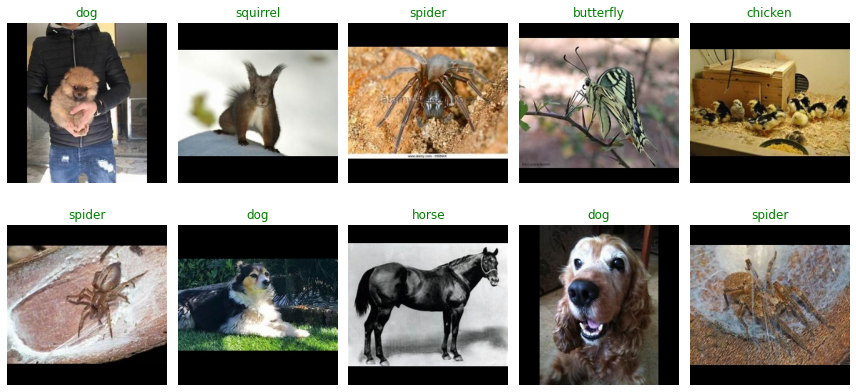

In [11]:
display_image_grid(train_images_filepaths[:10])

In [12]:
class Animal10Dataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('_')[0]
        label = CLASS_NUMBER[label]
        return img_transformed, label

In [13]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [14]:
train_dataset = Animal10Dataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = Animal10Dataset(val_images_filepahts, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = Animal10Dataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
4


In [15]:
train_iterator = DataLoader(train_dataset, batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([2, 7, 1, 6, 6, 7, 0, 0, 4, 3, 8, 4, 8, 4, 4, 0, 9, 4, 6, 2, 8, 2, 9, 2,
        3, 1, 3, 9, 7, 0, 0, 0])


In [16]:
pretrained_model=models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(512, 10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
model = pretrained_model
if(torch.cuda.is_available()==True):
    model=pretrained_model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

loss=nn.CrossEntropyLoss()

In [18]:
nb_epochs = 5
acc_tot=np.zeros(nb_epochs)
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()
    model.train()     
    for batch in train_iterator: 
        x,y = batch
        if(torch.cuda.is_available()==True):
            x=x.cuda()
            y=y.cuda()        
        # 1 forward
        l = model(x) # l: logits
        #2 compute the objective function
        J = loss(l,y)
        # 3 cleaning the gradients
        model.zero_grad()
        # optimiser.zero_grad()
        # params.grad.zero_()
        # 4 accumulate the partial derivatives of J wrt params
        J.backward()
        # 5 step in the opposite direction of the gradient
        optimizer.step()
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean())
    print(f'Epoch {epoch + 1}', end=', ')
    print(f'training loss: {torch.tensor(losses).mean():.2f}', end=', ')
    print(f'training accuracy: {torch.tensor(accuracies).mean():.2f}')
    losses = list()
    accuracies = list() 
    model.eval()
    for batch in valid_iterator: 
        x,y = batch
        if(torch.cuda.is_available()==True):
            x=x.cuda()
            y=y.cuda()
        with torch.no_grad(): 
            l = model(x)
        #2 compute the objective function
        J = loss(l,y)
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean())
    print(f'Epoch {epoch + 1}',end=', ')
    print(f'validation loss: {torch.tensor(losses).mean():.2f}', end=', ')
    print(f'validation accuracy: {torch.tensor(accuracies).mean():.2f}')
    acc_tot[epoch]=torch.tensor(accuracies).mean().numpy()

Epoch 1, training loss: 0.37, training accuracy: 0.90
Epoch 1, validation loss: 0.15, validation accuracy: 0.96
Epoch 2, training loss: 0.15, training accuracy: 0.96
Epoch 2, validation loss: 0.13, validation accuracy: 0.96
Epoch 3, training loss: 0.11, training accuracy: 0.97
Epoch 3, validation loss: 0.12, validation accuracy: 0.96
Epoch 4, training loss: 0.09, training accuracy: 0.98
Epoch 4, validation loss: 0.11, validation accuracy: 0.97
Epoch 5, training loss: 0.08, training accuracy: 0.98
Epoch 5, validation loss: 0.11, validation accuracy: 0.97


In [19]:
def imformat(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return(inp)

In [20]:
dataset = ImageFolder('/content/test_img')

In [21]:
class_names = dataset.classes
t_inv = {v: k for k, v in translate.items()}

In [22]:
class_names

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

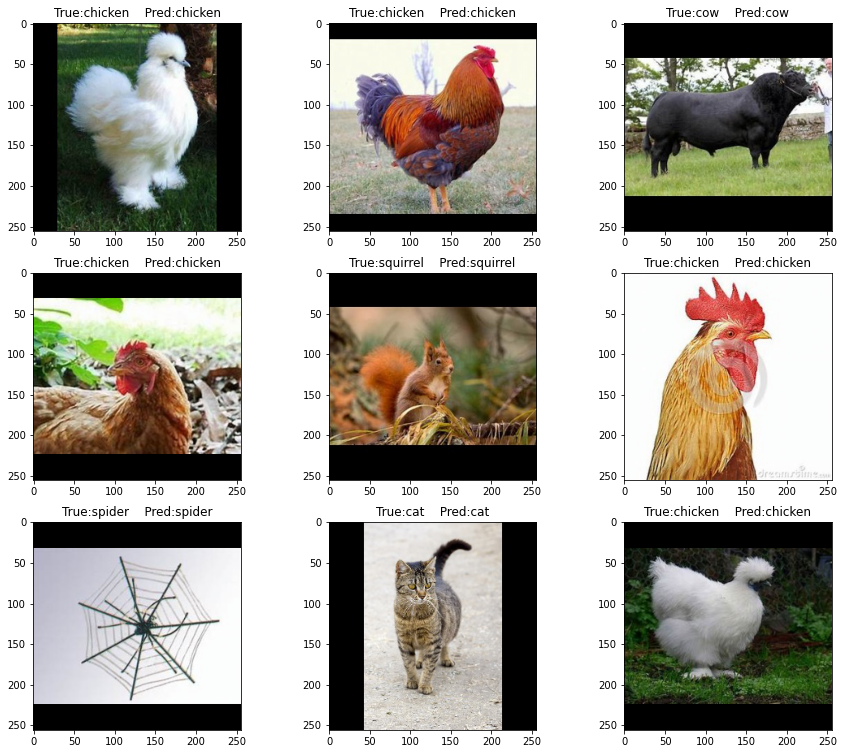

In [23]:
train_loader2 = torch.utils.data.DataLoader(test_dataset, batch_size=9)
plt.figure(figsize=(15, 13))
inputs, classes = next(iter(train_loader2))

preds=model(inputs.cuda()).argmax(dim=1)

for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    img=imformat(inputs[i])
    plt.imshow((img))
    try:
        plt.title('True:'+str(class_names[classes[i]])+'    Pred:'+str(class_names[preds[i]]))
    except:
        plt.title('True:'+str(translate[class_names[classes[i]]])+'    Pred:'+str(translate[class_names[preds[i]]]))
    if(i==9):
        plt.axis("off")